In [1]:
import glob
import numpy as np
import matplotlib.pyplot as plt
from keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array, array_to_img
import os
import shutil
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from keras.models import Sequential
from keras import optimizers
from sklearn.preprocessing import LabelEncoder

np.random.seed(42)
%matplotlib inline

Using TensorFlow backend.
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:519: FutureWarn

In [3]:
files = glob.glob("dataset/train/*")

cat_files = [fn for fn in files if 'cat' in fn]
dog_files = [fn for fn in files if 'dog' in fn]
len(cat_files), len(dog_files)

(12500, 12500)

In [4]:
cat_train = np.random.choice(cat_files, size=1500, replace=False)
dog_train = np.random.choice(dog_files, size=1500, replace=False)

cat_files = list(set(cat_files) - set(cat_train))
dog_files = list(set(dog_files) - set(dog_train))

cat_val = np.random.choice(cat_files, size=500, replace=False)
dog_val = np.random.choice(dog_files, size=500, replace=False)

cat_files = list(set(cat_files) - set(cat_val))
dog_files = list(set(dog_files) - set(dog_val))

cat_test = np.random.choice(cat_files, size=500, replace=False)
dog_test = np.random.choice(dog_files, size=500, replace=False)

print("Cat datasets:", cat_train.shape, cat_val.shape, cat_test.shape)
print("Dog datasets:", dog_train.shape, dog_val.shape, dog_test.shape)

Cat datasets: (1500,) (500,) (500,)
Dog datasets: (1500,) (500,) (500,)


In [5]:
train_dir = 'train_data'
val_dir = 'val_data'
test_dir = 'test_data'

train_files = np.concatenate([cat_train, dog_train])
validate_files = np.concatenate([cat_val, dog_val])
test_files = np.concatenate([cat_test, dog_test])

os.mkdir(train_dir) if not os.path.isdir(train_dir) else None
os.mkdir(val_dir) if not os.path.isdir(val_dir) else None
os.mkdir(test_dir) if not os.path.isdir(test_dir) else None

for fn in train_files:
    shutil.copy(fn, train_dir)
    
for fn in validate_files:
    shutil.copy(fn, val_dir)
    
for fn in test_files:
    shutil.copy(fn, test_dir)

In [2]:
IMG_DIM = (150, 150)

train_files = glob.glob("train_data/*")
train_imgs = [img_to_array(load_img(img, target_size=IMG_DIM)) for img in train_files]
train_imgs = np.array(train_imgs)
train_labels = [fn.split('/')[1].split('.')[0].strip() for fn in train_files]

validation_files = glob.glob("val_data/*")
validation_imgs = [img_to_array(load_img(img, target_size=IMG_DIM)) for img in validation_files]
validation_imgs = np.array(validation_imgs)
validation_labels = [fn.split("/")[1].split('.')[0].strip() for fn in validation_files]

print("Train dataset shape:", train_imgs.shape, "\tvalidation dataset shape:", validation_imgs.shape)

Train dataset shape: (3000, 150, 150, 3) 	validation dataset shape: (1000, 150, 150, 3)


(150, 150, 3)


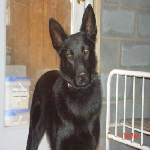

In [3]:
train_imgs_scaled = train_imgs.astype('float32')
validation_imgs_scaled = validation_imgs.astype('float32')
train_imgs_scaled /= 255
validation_imgs_scaled /= 255

print(train_imgs[0].shape)
array_to_img(train_imgs[0])

In [4]:
batch_size = 30
num_classes = 2
epochs = 30
input_shape = (150, 150, 3)

le = LabelEncoder()

le.fit(train_labels)
train_labels_enc = le.transform(train_labels)
validation_labels_enc = le.transform(validation_labels)

print(train_labels[1495:1505], train_labels_enc[1495:1505])

['dog', 'cat', 'cat', 'cat', 'dog', 'dog', 'dog', 'cat', 'dog', 'cat'] [1 0 0 0 1 1 1 0 1 0]


# Model 1: Naive CNN

In [27]:
model = Sequential()

model.add(Conv2D(16, kernel_size=(3, 3), activation='relu', input_shape=input_shape))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer=optimizers.RMSprop(), metrics=['accuracy'])

model.summary()


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 148, 148, 16)      448       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 74, 74, 16)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 72, 72, 64)        9280      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 17, 17, 128)       0         
_________________________

In [28]:
history = model.fit(x=train_imgs_scaled, 
                    y=train_labels_enc, 
                    validation_data=(validation_imgs_scaled, validation_labels_enc),
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1)


Train on 3000 samples, validate on 1000 samples
Epoch 1/30
3000/3000 [==============================] - 41s 14ms/step - loss: 0.9191 - accuracy: 0.5430 - val_loss: 0.6662 - val_accuracy: 0.6150
Epoch 2/30
3000/3000 [==============================] - 45s 15ms/step - loss: 0.6534 - accuracy: 0.6420 - val_loss: 0.5864 - val_accuracy: 0.6880
Epoch 3/30
3000/3000 [==============================] - 46s 15ms/step - loss: 0.5653 - accuracy: 0.7137 - val_loss: 0.5497 - val_accuracy: 0.7180
Epoch 4/30
3000/3000 [==============================] - 46s 15ms/step - loss: 0.5024 - accuracy: 0.7530 - val_loss: 0.5466 - val_accuracy: 0.7290
Epoch 5/30
3000/3000 [==============================] - 46s 15ms/step - loss: 0.4079 - accuracy: 0.8137 - val_loss: 0.5863 - val_accuracy: 0.7430
Epoch 6/30
3000/3000 [==============================] - 45s 15ms/step - loss: 0.3239 - accuracy: 0.8540 - val_loss: 0.6307 - val_accuracy: 0.7370
Epoch 7/30
3000/3000 [==============================] - 45s 15ms/step - los

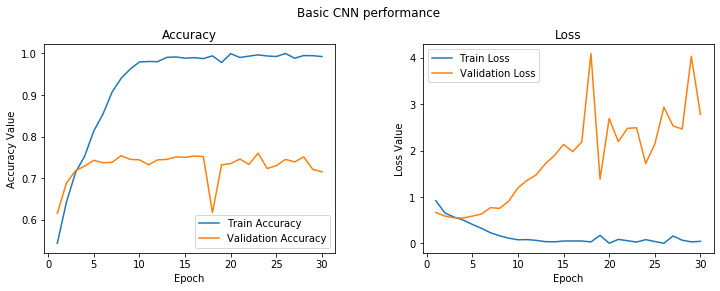

In [31]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
t = f.suptitle("Basic CNN performance", fontsize=12)
f.subplots_adjust(top=0.85, wspace=0.3)

epoch_list = list(range(1, 31))
ax1.plot(epoch_list, history.history['accuracy'], label='Train Accuracy')
ax1.plot(epoch_list, history.history['val_accuracy'], label='Validation Accuracy')
ax1.set_xticks(np.arange(0, 31, 5))
ax1.set_ylabel('Accuracy Value')
ax1.set_xlabel('Epoch')
ax1.set_title('Accuracy')
l1 = ax1.legend(loc='best')

ax2.plot(epoch_list, history.history['loss'], label='Train Loss')
ax2.plot(epoch_list, history.history['val_loss'], label='Validation Loss')
ax2.set_xticks(np.arange(0, 31, 5))
ax2.set_ylabel('Loss Value')
ax2.set_xlabel('Epoch')
ax2.set_title('Loss')
l2 = ax2.legend(loc='best')

# Model 2: CNN with Regularization

In [9]:
model = Sequential()

model.add(Conv2D(16, kernel_size=(3, 3), activation='relu', input_shape=input_shape))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer=optimizers.RMSprop(), metrics=['accuracy'])

history = model.fit(x=train_imgs_scaled, y=train_labels_enc, validation_data=(validation_imgs_scaled, validation_labels_enc),
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where

Train on 3000 samples, validate on 1000 samples
Epoch 1/30
3000/3000 [==============================] - 38s 13ms/step - loss: 0.7715 - accuracy: 0.5060 - val_loss: 0.6919 - val_accuracy: 0.5000
Epoch 2/30
3000/3000 [==============================] - 44s 15ms/step - loss: 0.7018 - accuracy: 0.5437 - val_loss: 0.6686 - val_accuracy: 0.5720
Epoch 3/30
3000/3000 [==============================] - 44s 15ms/step - loss: 0.6575 - accuracy: 0.6103 - val_loss: 0.6234 - val_accuracy: 0.6760
Epoch 4/30
3000/3000 [==============================] - 41s 14ms/step - loss: 0.6224 - accuracy: 0.6807 - val_loss: 0.6035 - val_accuracy: 0.6570
Epoch 5/30
3000/3000 [==============================] - 42s 14ms/step - loss: 0.5597 - accuracy: 0.7153 - val_loss: 0.5582 - val_accuracy: 0.7200
Epoch 6/30
3000/3000 [==============================] - 41s 14ms/step - loss: 0.5230 - accuracy: 0.7453 - val_loss: 0.5173 - va

In [10]:
model.save('cats_dogs_basic_cnn.h5')

# Model 3: CNN with Image Augmentation

In [5]:
train_datagen = ImageDataGenerator(rescale=1./255, zoom_range=0.3, rotation_range=50, width_shift_range=0.2, height_shift_range=0.2, shear_range=0.2, horizontal_flip=True, fill_mode='nearest')

val_datagen=ImageDataGenerator(rescale=1./255)

Labels: ['cat', 'cat', 'cat', 'cat', 'cat']


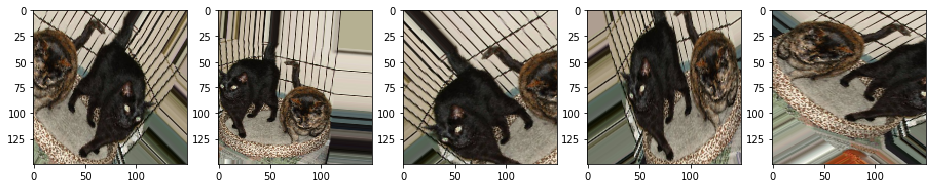

In [8]:
img_id = 1991
cat_generator = train_datagen.flow(train_imgs[img_id:img_id+1], train_labels[img_id:img_id+1],
                                   batch_size=1)
cat = [next(cat_generator) for i in range(0,5)]
fig, ax = plt.subplots(1,5, figsize=(16, 6))
print('Labels:', [item[1][0] for item in cat])
l = [ax[i].imshow(cat[i][0][0]) for i in range(0,5)]

In [ ]:
train_generator = train_datagen.flow(train_imgs, train_labels_enc, batch_size=30)
val_generator = val_datagen.flow(validation_imgs, validation_labels_enc, batch_size=20)
input_shape = (150, 150, 3)

from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from keras.models import Sequential
from keras import optimizers

model = Sequential()

model.add(Conv2D(16, kernel_size=(3, 3), activation='relu', input_shape=input_shape))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer=optimizers.RMSprop(lr=1e-4), metrics=['accuracy'])

history = model.fit_generator(train_generator, steps_per_epoch=100, epochs=100, validation_data=val_generator, validation_steps=50)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where

Epoch 1/100
100/100 [==============================] - 47s 469ms/step - loss: 0.6935 - accuracy: 0.5200 - val_loss: 0.6436 - val_accuracy: 0.5940
Epoch 2/100
100/100 [==============================] - 51s 506ms/step - loss: 0.6760 - accuracy: 0.5773 - val_loss: 0.7071 - val_accuracy: 0.6100
Epoch 3/100
100/100 [==============================] - 51s 507ms/step - loss: 0.6597 - accuracy: 0.6007 - val_loss: 0.7003 - val_accuracy: 0.5400
Epoch 4/100
100/100 [==============================] - 51s 510ms/step - loss: 0.6474 - accuracy: 0.6200 - val_loss: 0.5840 - val_accuracy: 0.6480
Epoch 5/100
100/100 [==============================] - 52s 520ms/step - loss: 0.6398 - accuracy: 0.6317 - val_loss: 0.5951 - val_accuracy: 0.6610
Epoch 6/100
100/100 [==============================] - 50s 504ms/step - loss: 0.6270 - accuracy: 0.6473 - val_loss: 0.6355 - val_accuracy: 0.6160
Epoch 7/100
100/100 [========